In [1]:
%matplotlib inline
# Importing standard Qiskit libraries and configuring account
from qiskit import QuantumCircuit, execute, Aer, IBMQ
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *

In [2]:
from qiskit import BasicAer
from qiskit.aqua import QuantumInstance
from qiskit.aqua import Operator, run_algorithm
from qiskit.aqua.input import EnergyInput
from qiskit.aqua.translators.ising import portfolio
from qiskit.aqua.translators.data_providers import RandomDataProvider
from qiskit.aqua.algorithms import VQE, QAOA, ExactEigensolver
from qiskit.aqua.components.optimizers import SPSA
from qiskit.aqua.components.variational_forms import RY
import qiskit.aqua.translators.ising.vehicle_routing as vr
import numpy as np
import datetime
import networkx as nx
import matplotlib.pyplot as plt
import math

In [56]:
#Create a random customer-customer distance matrix
N=4
# Initialize the problem by defining the parameters
n = 4  # number of nodes + depot (n+1)
K = 1  # number of vehicles

np.random.seed(1543)
#Array of X-Coordinates
#xs = (np.random.rand(n) - 0.5) * 10
xs = np.random.rand(n) * 10
#Array of Y-Coordinates
ys = np.random.rand(n) * 10

print (xs,ys)

def create_distance_matrix(xs,ys):
    n=len(xs)
    instance = np.zeros([n, n])
    for i in range(0, n):
        for j in range(i + 1, n):
            #print ('nodes = ',(xs[i],ys[i]),(xs[j],ys[j]))
            #Distance squared
            #instance[i, j] = (xs[i] - xs[j]) ** 2 + (ys[i] - ys[j]) ** 2
            instance[i, j] = math.sqrt((xs[i] - xs[j]) ** 2 + (ys[i] - ys[j]) ** 2)
            #jith element is made the same as ijth element - so that the matrix is a symmetric
            instance[j, i] = instance[i, j]
            #print (instance[i,j])
    return instance

instance=create_distance_matrix(xs,ys)
print ('distance matrix : \n',instance)

[5.51003914 7.55963937 4.35716491 0.42931423] [7.98724481 2.27415725 6.05534574 5.79231007]
distance matrix : 
 [[0.         6.06961535 2.2497451  5.53457353]
 [6.06961535 0.         4.9551215  7.95103364]
 [2.2497451  4.9551215  0.         3.93664816]
 [5.53457353 7.95103364 3.93664816 0.        ]]


{0: (5.5100391375334326, 7.9872448071072135), 1: (7.559639370825573, 2.2741572523311104), 2: (4.357164910072608, 6.055345738402197), 3: (0.4293142250893367, 5.7923100691603135)}
{(0, 1): 6, (0, 2): 2, (0, 3): 5, (1, 2): 4, (1, 3): 7, (2, 3): 3}


/opt/conda/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


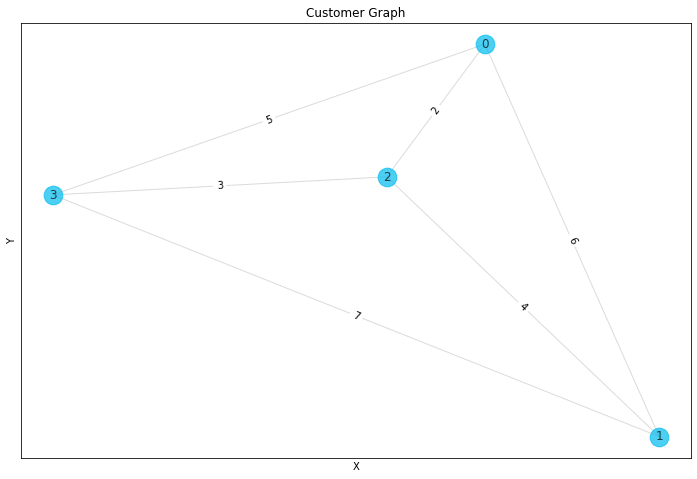

In [57]:
def plot_nodes (xs,ys):
    # plt.gca().invert_yaxis()
    # plt.gca().invert_xaxis()
    n=len(xs)
    keys = range(len(xs))
    pos = {}
    for k in keys:
        pos[k] = (xs[k], ys[k])
    print(pos)
    plt.figure()
    fig = plt.gcf()
    ax=fig.gca()
    fig.set_size_inches(12,8)
    plt.title('Customer Graph')
    plt.xlabel('X')
    plt.ylabel('Y')

    X = nx.Graph()
    # Add Edges
    for i in keys:
        for j in range(i+1, n):
            X.add_edge(i, j, length=int(instance[i][j]))

    nx.draw_networkx(X, pos, node_size=350, edge_color='#cccccc',ax=ax,
                     nodelist=[0, 1, 2, 3], node_color='#00bbee', alpha=0.7, with_labels=True)
    labels = nx.get_edge_attributes(X, "length")
    for k in labels.keys():
        labels[k] = int(labels[k])
    print(labels)
    nx.draw_networkx_edge_labels(X, pos, edge_labels=labels)
    #plt.xticks((0, 0.5, 1), ("0", "0.5", "1"))
    #plt.grid(True)
    plt.show()

plot_nodes(xs,ys)    

In [54]:
allpaths = nx.all_simple_paths(X, source=0, target=3)
#Print Hamiltonian Paths
selectedPaths = [path for path in list(allpaths) if len(path)==4]
print('All Hamiltonian Paths from 0-3 :\n', list(selectedPaths),'\n')
def cost_function(selectedPaths) :
    min_cost=1000
    min_cost_path = None
    for path in list(selectedPaths):
        total_length=5
        for k in range(len(path)-1):
            x,y = path[k], path[k+1]
            edge = X[x][y]
            length = edge['length']
            total_length += length
        print('{}: {}'.format(path, total_length))
        if min_cost>total_length:
            min_cost=total_length
            min_cost_path = path
    return min_cost, min_cost_path

min_cost, min_cost_path = cost_function(selectedPaths)
print('Minimum Cost : {} : {}'.format(min_cost_path, min_cost)  )      

All Hamiltonian Paths from 0-3 :
 [[0, 1, 2, 3], [0, 2, 1, 3]] 

[0, 1, 2, 3]: 18
[0, 2, 1, 3]: 18
Minimum Cost : [0, 1, 2, 3] : 18


[0 1 0 0 0 0 1 0 0 0 0 1 1 0 0 0]
0 1
1 2
2 3
{(0, 1): 6, (1, 2): 4, (2, 3): 3, (3, 0): 5}


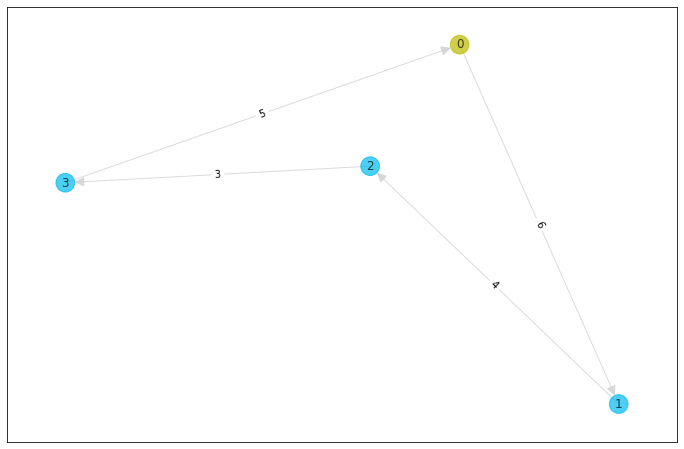

In [52]:
#Create the adjacency matrix
x=np.zeros((n,n), dtype=int)
for k in range(len(min_cost_path)-1):
    x[min_cost_path[k]][min_cost_path[k+1]]=1

x[min_cost_path[k+1]][0]=1
x=x.flatten()
print(x) 
# Visualize the solution
def draw_tsp_solution(G, order, pos):
    plt.figure()
    fig = plt.gcf()
    fig.set_size_inches(12,8)
    plt.title('Customer Graph : Cost = '+ str(classical_cost))
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.grid()

    G1 = G.copy()
    edges = list(G1.edges())
    G2 = G1.remove_edges_from(edges)
    G1 = G1.to_directed()
    n = len(order)
    for i in range(n-1):
        j = (i+1)#(i + 1) % n
        print(order[i],order[j])
        G1.add_edge(order[i], order[j],length=int(instance[order[i]][order[j]]))
    G1.add_edge(order[j], order[0],length=int(instance[order[j]][order[0]]))
    #create node colors array
    colors = np.full(n,'#00bbee')
    colors[order[0]]='#bbbb00'
    default_axes = plt.axes(frameon=True)
    ax=fig.gca()
    nx.draw_networkx(G1, pos, node_size=350, edge_color='#cccccc', ax=ax, #pos=pos, 
                     node_color=colors, alpha=0.7, arrowsize=20)
    labels = nx.get_edge_attributes(G1, "length")
    for k in labels.keys():
        labels[k] = int(labels[k])
    print(labels)
    nx.draw_networkx_edge_labels(G1, pos, edge_labels=labels)
    #plt.xticks((0, 0.5, 1), ("0", "0.5", "1"))
    #plt.grid(True)
    plt.show()


draw_tsp_solution(X,min_cost_path,pos)

In [11]:
from qiskit.aqua.translators.ising import tsp
n = 3
#num_qubits = n ** 2
#ins = tsp.random_tsp(n)
#insList = list(ins)
#It is important to real
coord = [[5.5100391375334326, 7.9872448071072135],
    [7.559639370825573, 2.2741572523311104],
    [4.357164910072608, 6.055345738402197],
    [0.4293142250893367, 5.7923100691603135]]
ins = tsp.TspData(name='AMC', dim=4, coord=coord, w=instance)
print(ins)
qubitOp, offset = tsp.get_tsp_qubitops(ins)
algo_input = EnergyInput(qubitOp)
print('Paulis: ',qubitOp.aer_paulis,'\n')
print('Flat Paulis: ',qubitOp.get_flat_pauli_list(),'\n')
print('\nmatrix: ',qubitOp.matrix,'\n')
print('num qubits: ',qubitOp.num_qubits,'\n')
print('Algorithm Input: ',algo_input,'\n')

TspData(name='AMC', dim=4, coord=[[5.5100391375334326, 7.9872448071072135], [7.559639370825573, 2.2741572523311104], [4.357164910072608, 6.055345738402197], [0.4293142250893367, 5.7923100691603135]], w=array([[0.        , 6.06961535, 2.2497451 , 5.53457353],
       [6.06961535, 0.        , 4.9551215 , 7.95103364],
       [2.2497451 , 4.9551215 , 0.        , 3.93664816],
       [5.53457353, 7.95103364, 3.93664816, 0.        ]]))
Paulis:  [[[-200006.9269669882, 0.0], 'IIIIIIIIIIIIIIIZ'], [[-200009.48788524352, 0.0], 'IIIIIIIIIIZIIIII'], [[1.5174038380744426, 0.0], 'IIIIIIIIIIZIIIIZ'], [[-200006.9269669882, 0.0], 'IIIIIIIIIIIIIIZI'], [[-200009.48788524352, 0.0], 'IIIIIIIIIZIIIIII'], [[1.5174038380744426, 0.0], 'IIIIIIIIIZIIIIZI'], [[-200006.9269669882, 0.0], 'IIIIIIIIIIIIIZII'], [[-200009.48788524352, 0.0], 'IIIIIIIIZIIIIIII'], [[1.5174038380744426, 0.0], 'IIIIIIIIZIIIIZII'], [[-200006.9269669882, 0.0], 'IIIIIIIIIIIIZIII'], [[-200009.48788524352, 0.0], 'IIIIIIIIIIIZIIII'], [[1.51740383807

In [12]:
#Making the Hamiltonian in its full form and getting the lowest eigenvalue and eigenvector
ee = ExactEigensolver(qubitOp, k=1)
result = ee.run()

In [47]:
print('energy:', result['energy'])
print('tsp objective:', result['energy'] + offset)
import sys
np.set_printoptions(threshold=1000)
print(result['eigvecs'])
x = tsp.sample_most_likely(result['eigvecs'][0])
print('feasible:', tsp.tsp_feasible(x))
z = tsp.get_tsp_solution(x)
print('solution:', z)
print('solution objective:', tsp.tsp_value(z, ins.w))
print(pos)

energy: -1443573.1631420923
tsp objective: 156488.2303324577
[[ 1.95764752e-05+0.j  2.67487292e-06+0.j  4.50815205e-05+0.j ...
  -1.21737486e-08+0.j  9.72384352e-08+0.j -7.79814263e-08+0.j]]
feasible: True
solution: [2, 3, 0, 1]
solution objective: 20.4959585404081
{0: (5.5100391375334326, 7.9872448071072135), 1: (7.559639370825573, 2.2741572523311104), 2: (4.357164910072608, 6.055345738402197), 3: (0.4293142250893367, 5.7923100691603135)}


2 3
3 0
0 1
{(0, 1): 6, (1, 2): 4, (2, 3): 3, (3, 0): 5}


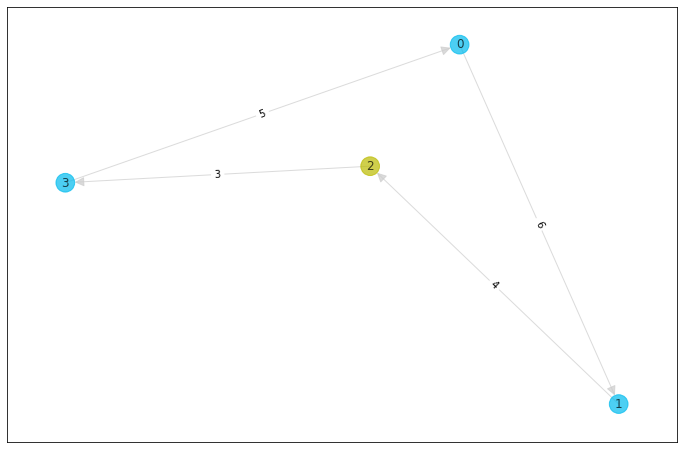

In [53]:
#draw_tsp_solution(G, best_order, colors, pos)
draw_tsp_solution(X, z, pos)

In [36]:
seed = 10598
import logging
from qiskit.aqua import set_qiskit_aqua_logging
set_qiskit_aqua_logging(logging.DEBUG)  # choose INFO, DEBUG to see the log

#Now we use the VQE that needs two algorithms as sub-components
#Sub-Component 1 : a local optimizer, we use SPSA/COBYLA(Constrained Optimization BY Linear Approximation) 
#from qiskit.aqua.components.optimizers
cobyla = COBYLA()
cobyla.set_options(maxiter=250)
spsa = SPSA(max_trials=300)
#Sub-Component 2 : a variational form, we use Ry from qiskit.aqua.components.variational_forms
#ry = RY(qubitOp.num_qubits, depth=3, entanglement='full')
ry = RY(qubitOp.num_qubits, depth=3, entanglement='linear')
#vqe = VQE(qubitOp, ry, cobyla, 'matrix')
vqe = VQE(qubitOp, ry, spsa, 'matrix')
vqe.random_seed = seed

backend = BasicAer.get_backend('statevector_simulator')
quantum_instance = QuantumInstance(backend, seed=seed, seed_transpiler=seed)

import time
start_time=time.time()
result = vqe.run(quantum_instance)
print("Ran For %s seconds" % (time.time() - start_time))
"""
algorithm_cfg = {
    'name': 'VQE',
    'operator_mode': 'matrix'
}

optimizer_cfg = {
    'name': 'SPSA',
    'max_trials': 300
}

var_form_cfg = {
    'name': 'RY',
    'depth': 5,
    'entanglement': 'linear'
}

params = {
    'problem': {'name': 'ising', 'random_seed': seed},
    'algorithm': algorithm_cfg,
    'optimizer': optimizer_cfg,
    'variational_form': var_form_cfg,
    'backend': {'provider': 'qiskit.BasicAer', 'name': 'statevector_simulator'}
}
result = run_algorithm(parahms,algo_input)
"""

2019-08-23 09:59:36,310:qiskit.aqua.parser.json_schema:DEBUG: Input: {
    "c0": 0.6283185307179586,
    "c1": 0.1,
    "c2": 0.602,
    "c3": 0.101,
    "c4": 0,
    "last_avg": 1,
    "max_trials": 300,
    "save_steps": 1,
    "skip_calibration": false
}
2019-08-23 09:59:36,311:qiskit.aqua.parser.json_schema:DEBUG: Input Schema: {
    "$schema": "http://json-schema.org/schema#",
    "additionalProperties": false,
    "id": "spsa_schema",
    "properties": {
        "c0": {
            "default": 0.6283185307179586,
            "type": "number"
        },
        "c1": {
            "default": 0.1,
            "type": "number"
        },
        "c2": {
            "default": 0.602,
            "type": "number"
        },
        "c3": {
            "default": 0.101,
            "type": "number"
        },
        "c4": {
            "default": 0,
            "type": "number"
        },
        "last_avg": {
            "default": 1,
            "minimum": 1,
            "type": "int

2019-08-23 09:59:36,320:qiskit.aqua.algorithms.adaptive.vq_algorithm:INFO: Starting optimizer.
bounds=[(-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.141592653589793), (-3.141592653589793, 3.1415926535897

2019-08-23 10:00:01,660:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 27 returned -513583.83416134224
2019-08-23 10:00:02,490:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 28 returned -462176.48451417935
2019-08-23 10:00:03,474:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 29 returned -428228.9336172969
2019-08-23 10:00:04,423:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 30 returned -524807.5662844853
2019-08-23 10:00:04,425:qiskit.aqua.components.optimizers.spsa:DEBUG: calibration step # 15 of 25
2019-08-23 10:00:05,248:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 31 returned -633984.4919048933
2019-08-23 10:00:06,189:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 32 returned -358518.24301097624
2019-08-23 10:00:07,140:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 33 returned -449061.1337410587
2019-08-23 10:00:08,101:qiskit.aqua.algorithms.adaptive.vqe.vqe:IN

2019-08-23 10:00:43,104:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 72 returned -749655.2798054848
2019-08-23 10:00:43,106:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 10: -783112.5571637
2019-08-23 10:00:43,107:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 10: -749655.2798055
2019-08-23 10:00:44,080:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 73 returned -827105.7831491906
2019-08-23 10:00:44,925:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 74 returned -711278.7800786515
2019-08-23 10:00:44,927:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 11: -827105.7831492
2019-08-23 10:00:44,927:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 11: -711278.7800787
2019-08-23 10:00:45,884:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 75 returned -837147.2252723716
2019

2019-08-23 10:01:12,658:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 26: -1063162.8674322
2019-08-23 10:01:13,612:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 105 returned -1101934.2580958046
2019-08-23 10:01:14,441:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 106 returned -1054595.7237824253
2019-08-23 10:01:14,445:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 27: -1101934.2580958
2019-08-23 10:01:14,446:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 27: -1054595.7237824
2019-08-23 10:01:15,398:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 107 returned -1087648.316518804
2019-08-23 10:01:16,366:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 108 returned -1099240.473190714
2019-08-23 10:01:16,368:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 28: -1087648.31

2019-08-23 10:01:44,164:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 138 returned -1204655.387796466
2019-08-23 10:01:44,166:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 43: -1201174.6596469
2019-08-23 10:01:44,166:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 43: -1204655.3877965
2019-08-23 10:01:45,120:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 139 returned -1209290.9677348656
2019-08-23 10:01:46,075:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 140 returned -1193301.2459650182
2019-08-23 10:01:46,077:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 44: -1209290.9677349
2019-08-23 10:01:46,077:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 44: -1193301.2459650
2019-08-23 10:01:47,041:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 141 returned -1208889.7503

2019-08-23 10:02:13,807:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 59: -1226058.6936475
2019-08-23 10:02:14,761:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 171 returned -1223655.135547643
2019-08-23 10:02:15,718:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 172 returned -1216276.2311822746
2019-08-23 10:02:15,719:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 60: -1223655.1355476
2019-08-23 10:02:15,721:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 60: -1216276.2311823
2019-08-23 10:02:16,679:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 173 returned -1233211.6734559033
2019-08-23 10:02:17,497:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 174 returned -1226595.4253776015
2019-08-23 10:02:17,499:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 61: -1233211.6

2019-08-23 10:02:45,404:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 204 returned -1242998.9514148994
2019-08-23 10:02:45,406:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 76: -1247126.4224707
2019-08-23 10:02:45,408:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 76: -1242998.9514149
2019-08-23 10:02:46,369:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 205 returned -1264546.2069338227
2019-08-23 10:02:47,196:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 206 returned -1223194.9968540578
2019-08-23 10:02:47,198:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 77: -1264546.2069338
2019-08-23 10:02:47,199:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 77: -1223194.9968541
2019-08-23 10:02:48,158:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 207 returned -1253841.669

2019-08-23 10:03:15,045:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 92: -1287835.7729308
2019-08-23 10:03:15,995:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 237 returned -1285405.4742671032
2019-08-23 10:03:16,819:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 238 returned -1268480.4992291378
2019-08-23 10:03:16,821:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 93: -1285405.4742671
2019-08-23 10:03:16,824:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 93: -1268480.4992291
2019-08-23 10:03:17,784:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 239 returned -1266950.0007945173
2019-08-23 10:03:18,732:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 240 returned -1294105.2441078536
2019-08-23 10:03:18,735:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 94: -1266950.

2019-08-23 10:03:45,667:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 269 returned -1299232.0133298007
2019-08-23 10:03:46,501:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 270 returned -1296669.9489058852
2019-08-23 10:03:46,503:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 109: -1299232.0133298
2019-08-23 10:03:46,503:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 109: -1296669.9489059
2019-08-23 10:03:47,473:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 271 returned -1294376.605431351
2019-08-23 10:03:48,441:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 272 returned -1292839.669769806
2019-08-23 10:03:48,443:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 110: -1294376.6054314
2019-08-23 10:03:48,444:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 110: -129283

2019-08-23 10:04:17,490:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 302 returned -1316823.8484719424
2019-08-23 10:04:17,493:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 125: -1319431.0519749
2019-08-23 10:04:17,493:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 125: -1316823.8484719
2019-08-23 10:04:18,631:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 303 returned -1309452.1174675198
2019-08-23 10:04:19,773:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 304 returned -1322833.6680264417
2019-08-23 10:04:19,775:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 126: -1309452.1174675
2019-08-23 10:04:19,776:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 126: -1322833.6680264
2019-08-23 10:04:20,712:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 305 returned -1304899

2019-08-23 10:04:47,345:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 141: -1326071.2051603
2019-08-23 10:04:47,345:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 141: -1329449.2029371
2019-08-23 10:04:48,301:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 335 returned -1317873.3237730186
2019-08-23 10:04:49,254:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 336 returned -1323759.9606093266
2019-08-23 10:04:49,256:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 142: -1317873.3237730
2019-08-23 10:04:49,257:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 142: -1323759.9606093
2019-08-23 10:04:50,194:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 337 returned -1316930.0228545766
2019-08-23 10:04:51,136:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 338 returned -1341264

2019-08-23 10:05:16,741:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 157: -1330429.6290372
2019-08-23 10:05:17,692:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 367 returned -1342961.5587216779
2019-08-23 10:05:18,641:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 368 returned -1339255.897845263
2019-08-23 10:05:18,643:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 158: -1342961.5587217
2019-08-23 10:05:18,644:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 158: -1339255.8978453
2019-08-23 10:05:19,591:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 369 returned -1339358.3681174046
2019-08-23 10:05:20,557:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 370 returned -1339624.5051906884
2019-08-23 10:05:20,559:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 159: -13393

2019-08-23 10:05:47,215:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 399 returned -1349566.9741545427
2019-08-23 10:05:48,192:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 400 returned -1356710.7416957293
2019-08-23 10:05:48,194:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 174: -1349566.9741545
2019-08-23 10:05:48,195:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 174: -1356710.7416957
2019-08-23 10:05:49,163:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 401 returned -1363212.4655275287
2019-08-23 10:05:50,108:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 402 returned -1340594.5591145935
2019-08-23 10:05:50,110:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 175: -1363212.4655275
2019-08-23 10:05:50,110:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 175: -1340

2019-08-23 10:06:17,662:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 432 returned -1353885.2467966506
2019-08-23 10:06:17,664:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 190: -1363176.5202536
2019-08-23 10:06:17,665:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 190: -1353885.2467967
2019-08-23 10:06:18,605:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 433 returned -1358869.6285455185
2019-08-23 10:06:19,556:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 434 returned -1357871.95012215
2019-08-23 10:06:19,558:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 191: -1358869.6285455
2019-08-23 10:06:19,559:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 191: -1357871.9501221
2019-08-23 10:06:20,365:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 435 returned -1366437.5

2019-08-23 10:06:47,203:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 206: -1369490.6739915
2019-08-23 10:06:47,203:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 206: -1370202.5188798
2019-08-23 10:06:48,184:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 465 returned -1365283.6461762444
2019-08-23 10:06:49,157:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 466 returned -1373471.2034931474
2019-08-23 10:06:49,159:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 207: -1365283.6461762
2019-08-23 10:06:49,160:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 207: -1373471.2034931
2019-08-23 10:06:49,974:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 467 returned -1362476.1989506728
2019-08-23 10:06:50,940:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 468 returned -1361457

2019-08-23 10:07:16,660:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 222: -1375279.5434455
2019-08-23 10:07:17,619:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 497 returned -1356763.3911249216
2019-08-23 10:07:18,577:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 498 returned -1387761.2652692387
2019-08-23 10:07:18,579:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 223: -1356763.3911249
2019-08-23 10:07:18,580:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 223: -1387761.2652692
2019-08-23 10:07:19,394:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 499 returned -1367276.0127585651
2019-08-23 10:07:20,336:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 500 returned -1373910.6716415936
2019-08-23 10:07:20,338:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 224: -1367

2019-08-23 10:07:47,034:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 529 returned -1374355.1403270485
2019-08-23 10:07:47,990:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 530 returned -1390792.435921949
2019-08-23 10:07:47,992:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 239: -1374355.1403270
2019-08-23 10:07:47,994:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 239: -1390792.4359219
2019-08-23 10:07:48,813:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 531 returned -1386908.0382873765
2019-08-23 10:07:49,755:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 532 returned -1373020.816084125
2019-08-23 10:07:49,758:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 240: -1386908.0382874
2019-08-23 10:07:49,759:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 240: -137302

2019-08-23 10:08:17,475:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 562 returned -1393814.7325407548
2019-08-23 10:08:17,477:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 255: -1404399.6840544
2019-08-23 10:08:17,477:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 255: -1393814.7325408
2019-08-23 10:08:18,292:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 563 returned -1408138.7472549002
2019-08-23 10:08:19,240:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 564 returned -1398101.2234161645
2019-08-23 10:08:19,242:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 256: -1408138.7472549
2019-08-23 10:08:19,243:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 256: -1398101.2234162
2019-08-23 10:08:20,186:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 565 returned -1408605

2019-08-23 10:08:46,895:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 271: -1408437.3639271
2019-08-23 10:08:46,896:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 271: -1406870.0314217
2019-08-23 10:08:47,727:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 595 returned -1408922.3139065895
2019-08-23 10:08:48,689:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 596 returned -1421675.921503566
2019-08-23 10:08:48,694:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 272: -1408922.3139066
2019-08-23 10:08:48,695:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 272: -1421675.9215036
2019-08-23 10:08:49,641:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 597 returned -1413937.8975245045
2019-08-23 10:08:50,599:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 598 returned -1409038.

2019-08-23 10:09:16,525:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 287: -1423592.9893759
2019-08-23 10:09:17,343:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 627 returned -1412589.5636532896
2019-08-23 10:09:18,304:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 628 returned -1433041.751605935
2019-08-23 10:09:18,306:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 288: -1412589.5636533
2019-08-23 10:09:18,307:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta- for step # 288: -1433041.7516059
2019-08-23 10:09:19,250:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 629 returned -1422289.9783353503
2019-08-23 10:09:20,190:qiskit.aqua.algorithms.adaptive.vqe.vqe:INFO: Energy evaluation 630 returned -1421393.3075862261
2019-08-23 10:09:20,192:qiskit.aqua.components.optimizers.spsa:DEBUG: Objective function at theta+ for step # 289: -14222

Ran For 604.2635536193848 seconds


"\nalgorithm_cfg = {\n    'name': 'VQE',\n    'operator_mode': 'matrix'\n}\n\noptimizer_cfg = {\n    'name': 'SPSA',\n    'max_trials': 300\n}\n\nvar_form_cfg = {\n    'name': 'RY',\n    'depth': 5,\n    'entanglement': 'linear'\n}\n\nparams = {\n    'problem': {'name': 'ising', 'random_seed': seed},\n    'algorithm': algorithm_cfg,\n    'optimizer': optimizer_cfg,\n    'variational_form': var_form_cfg,\n    'backend': {'provider': 'qiskit.BasicAer', 'name': 'statevector_simulator'}\n}\nresult = run_algorithm(parahms,algo_input)\n"

{'num_optimizer_evals': None, 'min_val': -1443573.1631420923, 'opt_params': array([-9.92982794e-02,  1.77112045e+00, -4.30307802e-01, -8.21219395e-01,
        2.75179649e+00,  7.37755624e-01,  3.19623777e+00,  1.20691629e+00,
       -2.66470069e+00,  3.04500870e+00, -2.47725103e+00,  6.25407632e-02,
        1.52755035e+00,  1.09462317e+00,  3.09954427e+00,  2.03375335e-01,
        3.16686705e+00,  3.87951431e-01,  3.23274405e+00,  1.37996397e+00,
       -1.48569176e+00,  2.68838729e+00, -4.23319571e-02,  1.56062998e+00,
        1.20850690e+00, -2.54442614e+00,  4.11536907e+00, -1.19978709e-03,
       -1.47647658e+00,  1.54353703e+00,  3.11845413e+00,  1.51307000e+00,
       -1.94454383e+00, -2.18116552e+00,  5.93388779e-01, -4.04567464e+00,
        3.60153036e+00, -3.24121369e+00, -3.31667818e+00,  4.03930878e-01,
       -2.57666767e+00,  3.56815937e-01,  3.09185383e+00, -3.39664951e-01,
        1.16522277e+00, -3.80607968e+00, -3.04916869e+00,  1.96486829e+00,
       -1.10680794e+00, 

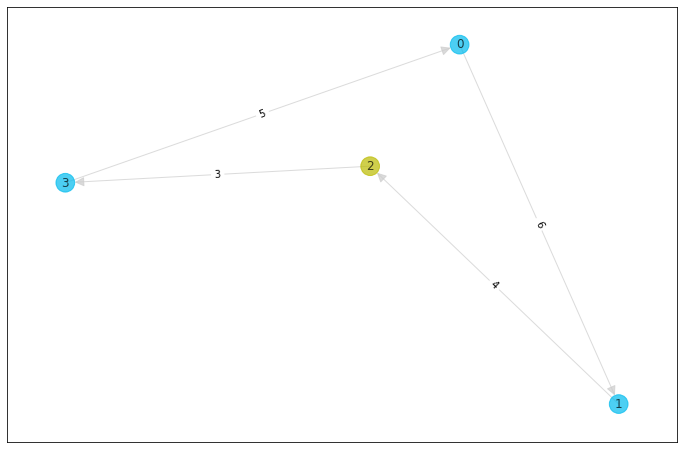

In [55]:
print(result)    
print('energy:', result['energy'])
print('time:', result['eval_time'])
#print('tsp objective:', result['energy'] + offset)
x = tsp.sample_most_likely(result['eigvecs'][0])
print('feasible:', tsp.tsp_feasible(x))
z = tsp.get_tsp_solution(x)
print('solution:', z)
print('solution objective:', tsp.tsp_value(z, ins.w))
draw_tsp_solution(X, z, pos)

In [ ]:
#Aggregation
#You will have 20 z arrays - 
#[[0,1,2,3], [0,7,6,8], [0,9,11,10]...]
#3, 8, 10, .... - with these create an array
#3 & 8 - whether their distance is less than threshold
#if it is - the join 3-8 and remove 3,8 from the array